In [1]:
%cd ..

/home/gmcirco/Documents/Projects/GridPred


In [ ]:
import pandas as pd

from src.evaluate.metrics import evaluate, pai, pei, rri
from src.model.random_forest import RandomForestGridPred
from src.plotting import visualize_predictions
from src.prediction import GridPred

It's helpful to define all of our inputs. At a minimum we need to provide a path to a .csv file containing the longitude and latitude of crime incidents, as well as the name of a field for a date variable. 

In [ ]:
# define the inputs
crime_data = "input/hartford_robberies.csv"
predictor_features = "input/hartford_pois.csv"
region_shapefile = "input/hartford.shp"

# define variable names
time_var = "year"
features_var = "types"

# spatial projections
# includes the coordinate reference system of the input crime data
# as well as a desired projection for all spatial objects
input_crime_crs = 3508
projected_crs = 3508

# size of the grid to use (in units based on projection)
grid_size = 400


# This initalizes the GridPred class with the specified data
gridpred = GridPred(
    input_crime_data=crime_data,
    input_features_data=predictor_features,
    input_study_region=region_shapefile,
    crime_time_variable=time_var,
    features_names_variable=features_var,
    input_crs=input_crime_crs,
)

The `prepare_data` function takes all of our inputs and creates a tabular dataset `X` that can be used in a prediction model. Printing the object below shows that we have the counts of 2017 robberies, as well as the nearest distance to a variety of potentially criminogenic features (gas stations, bars, night clubs, etc...)

In [ ]:
# This generates the input to the regression model
gridpred.prepare_data(
    grid_cell_size=grid_size,
    do_projection=True,
    projected_crs=projected_crs
)

# Look at top 5 values in the predictor matrix
# is stored as a class object `X`
gridpred.X.head(5).round(2)

,crimes_2017,liquor_store,bar,gas_station,restaurant,pharmacy,night_club,x,y
231,0,641.01,648.26,2878.30,4489.75,5964.84,9438.41,1010113.10,824653.91
308,0,254.13,255.45,2915.07,4217.04,5942.46,9098.14,1010511.83,824679.61
154,0,970.47,979.03,2892.32,4732.11,6006.24,9726.21,1009781.55,824629.96
232,0,751.07,744.97,2534.31,4231.56,5618.71,9241.02,1010119.00,825000.00
309,0,467.13,449.17,2605.54,3962.67,5622.69,8907.88,1010519.00,825000.00


In [19]:
# very basic demo model workflow
# can replace with xgboost or whatever model
X = gridpred.X
y = gridpred.y

rf = RandomForestGridPred(
    n_estimators=500, criterion="poisson", random_state=42
)
rf.fit(X, y)

In [20]:
# Predict
y_pred = rf.predict(X)

In [21]:
# print feature importances
# TODO: in future, can be logged and plotted
importances = pd.Series(rf.get_feature_importances(), index=X.columns)
print(importances.sort_values(ascending=False))

crimes_2017     0.270618
liquor_store    0.240522
pharmacy        0.089078
restaurant      0.084547
gas_station     0.081187
night_club      0.072135
bar             0.071431
y               0.053238
x               0.037243
dtype: float64


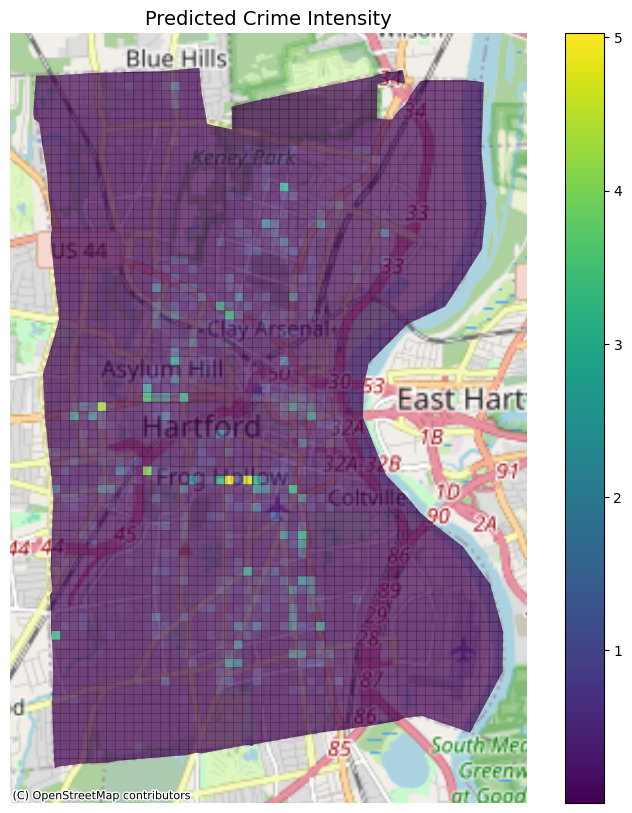

In [22]:
# plotting
region_grid = gridpred.region_grid
visualize_predictions(region_grid, y_pred)

We can compute a number of standard crime-prediction metrics like the Predictive Accuracy Index (PAI), the Predective Effecicency Index (PEI), and the Rate Recapture Index (RRI) which are already pre-defined in the libray. Furthermore, you can pass any valid function to `evaluate`.

In [25]:
# Pass a dict of pre-defined library metrics
# NOTE: You can also just pass the funcs as a list as well

METRICS = {'PAI': pai, 'PEI': pei, 'RRI': rri}

print(
    evaluate(
        y_true=gridpred.eval,
        y_pred=y_pred,
        metrics=METRICS,
        region_grid=region_grid,
        round_digits=2
    )
)


{'PAI': 14.21, 'PEI': 0.49, 'RRI': 14.96}
